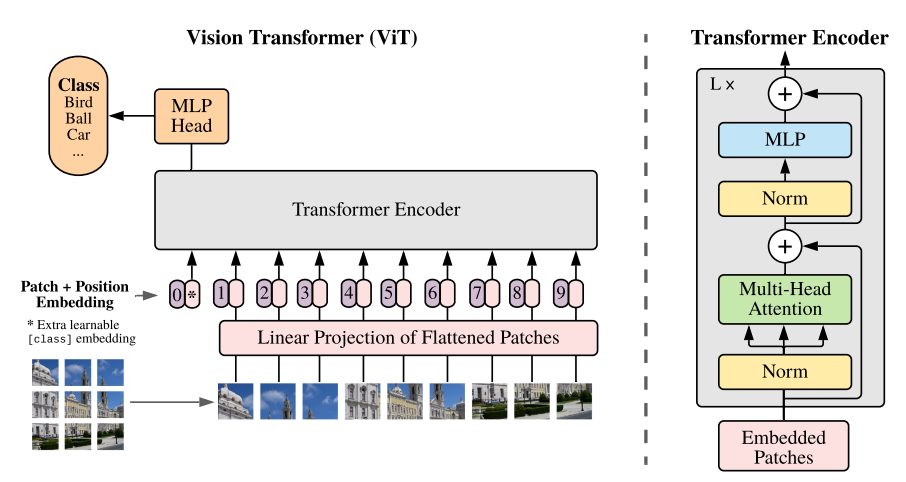

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

import pickle
from pathlib import Path
from pprint import pprint

# CIFAR100 images

The CIFAR-100 dataset consists of 60000 32x32 colour images in 100 classes, with 600 images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). There are 50000 training images and 10000 test images.

In [2]:
train_dict = pickle.load(Path('/kaggle/input/cifar100/train').open('rb'), encoding='bytes')
print(f'Train Dictionary Keys: {list(train_dict.keys())}')

test_dict = pickle.load(Path('/kaggle/input/cifar100/test').open('rb'), encoding='bytes')
print(f'Test Dictionary Keys: {list(test_dict.keys())}')

labels = pickle.load(Path('/kaggle/input/cifar100/meta').open('rb'))
pprint(labels, compact=True)

Train Dictionary Keys: [b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']
Test Dictionary Keys: [b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']
{'coarse_label_names': ['aquatic_mammals', 'fish', 'flowers', 'food_containers',
                        'fruit_and_vegetables', 'household_electrical_devices',
                        'household_furniture', 'insects', 'large_carnivores',
                        'large_man-made_outdoor_things',
                        'large_natural_outdoor_scenes',
                        'large_omnivores_and_herbivores', 'medium_mammals',
                        'non-insect_invertebrates', 'people', 'reptiles',
                        'small_mammals', 'trees', 'vehicles_1', 'vehicles_2'],
 'fine_label_names': ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed',
                      'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy',
                      'bridge', 'bus', 'butterfly', 'camel', 'can', 'c

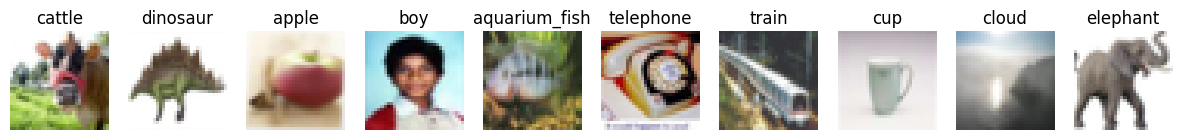

In [3]:
images = train_dict[b'data'].reshape(-1,3,32,32) # shape=(50000, 3, 32, 32)
images = np.transpose(images, axes=(0,2,3,1)) # shape=(50000, 32, 32, 3)

fig, axes = plt.subplots(1, 10, figsize=(15, 3), facecolor='white')

for i in range(10):
    img = images[i]
    lab = labels['fine_label_names'][train_dict[b'fine_labels'][i]]
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(lab)
plt.show()

In [4]:
(x_train, y_train) = (np.transpose(train_dict[b'data'].reshape(-1,3,32,32), axes=(0,2,3,1)), np.array(train_dict[b'fine_labels']))
(x_test, y_test) = (np.transpose(test_dict[b'data'].reshape(-1,3,32,32), axes=(0,2,3,1)), np.array(test_dict[b'fine_labels']))

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000,)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000,)


# ViT

# Implement image preprocessing

The preprocessing step will consist of 3 layers:
* one layer to normalize and resize the images
* one layer to do data augmentation 
* one layer to create patches

In [5]:
input_shape = (32, 32, 3) 
image_size = 72 
patch_size = 6  
num_patches = (image_size // patch_size) ** 2 #144

In [6]:
norm_and_resize = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="norm_and_resize",
)

norm_and_resize.layers[0].adapt(x_train)

## Implement data augmentation 

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

## Implement patch creation 

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2] 
        channels = input_shape[3] 
        num_patches_h = height // self.patch_size 
        num_patches_w = width // self.patch_size  
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [9]:
inputs = keras.Input(shape=input_shape)
x = layers.Resizing(image_size, image_size)(inputs)
x = data_augmentation(x)
outputs = Patches(patch_size)(x)
preproc = keras.Model(inputs=inputs, outputs=outputs)

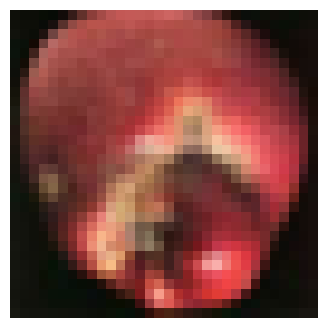

In [10]:
image = x_train[np.random.choice(range(x_train.shape[0]))] 

plt.figure(figsize=(4, 4))
plt.imshow(image.reshape(32,32,3))
plt.axis("off")
plt.show()

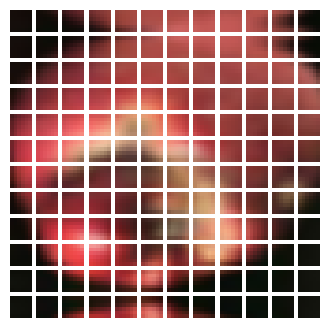

In [11]:
image = np.expand_dims(image, axis=0)
patches = preproc(image)
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

# Implement the patch encoding layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [12]:
projection_dim = 64

In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        
    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
         
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

# MLP

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Build the ViT model

In [15]:
num_classes = 100 
num_heads = 4
transformer_units = [projection_dim * 2,projection_dim]
transformer_layers = 8
mlp_head_units = [2048,1024]

In [16]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Normalize and resize
    preprocessed = norm_and_resize(inputs)
    # Augment data.
    augmented = data_augmentation(preprocessed)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Train the ViT

In [17]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.0334 - loss: 4.8905 - top-5-accuracy: 0.1186 - val_accuracy: 0.1098 - val_loss: 3.9315 - val_top-5-accuracy: 0.3104
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.0830 - loss: 4.0303 - top-5-accuracy: 0.2640 - val_accuracy: 0.1578 - val_loss: 3.5796 - val_top-5-accuracy: 0.4110
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.1204 - loss: 3.7478 - top-5-accuracy: 0.3475 - val_accuracy: 0.1932 - val_loss: 3.3741 - val_top-5-accuracy: 0.4626
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.1519 - loss: 3.5623 - top-5-accuracy: 0.4079 - val_accuracy: 0.2132 - val_loss: 3.2630 - val_top-5-accuracy: 0.4924
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.1747 - loss: 3.4455 - top-5-accuracy: 0.4389 - val_accuracy: 0.2388 - val_loss: 3.1125 - val_top-5-accuracy: 0.5292
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.1948 - loss: 3.306

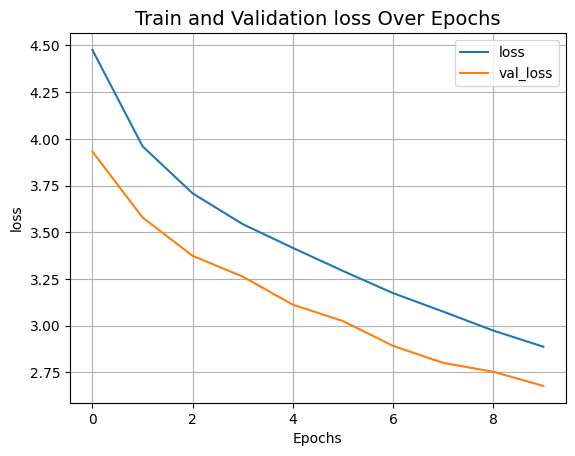

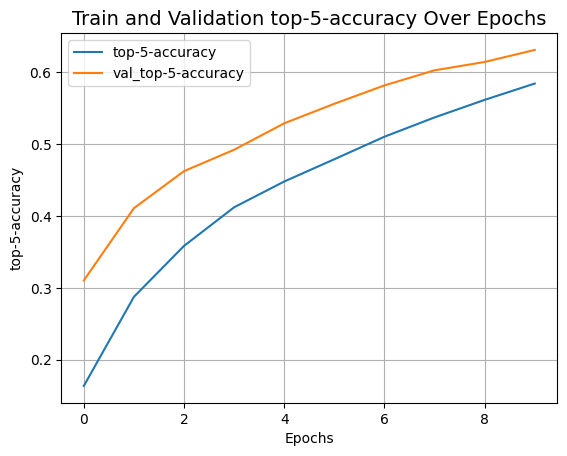

In [18]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")